In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [4]:
!pip install pycaret

     |████████████████████████████████| 301 kB 6.1 MB/s            
     |████████████████████████████████| 25.9 MB 3.3 MB/s            
     |████████████████████████████████| 24.2 MB 7.0 MB/s                      | 11.8 MB 43.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.4 MB 45.1 MB/s            �██████                         | 2.3 MB 45.1 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 40.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 636 kB 38.5 MB/s            
     |████████████████████████████████| 15.6 MB 430 kB/s             
     |████████████████████████████████| 167 kB 40.8 MB/s            


     |████████████████████████████████| 184 kB 39.5 MB/s            
     |████████████████████████████████| 1.0 MB 40.4 MB/s            
     |████████████████████████████████| 14.8 MB 624 kB/s             
     |████████████████████████████████| 79 kB 9.4 MB/s             
     |████████████████████████████████| 58 kB 1.5 MB/s             
  Preparing metadata (setup.py) ... done


  Created wheel for pyod: filename=pyod-0.9.7-py3-none-any.whl size=136277 sha256=95146ebe8843e0a5ba54c607bf48826cfb97b93392596da2fce7e01dd6796d4b
  Stored in directory: /root/.cache/pip/wheels/ce/14/ae/60cbb36511e59bc12f8f0883805f586db3b315972b54865d33
  Created wheel for databricks-cli: filename=databricks_cli-0.16.4-py3-none-any.whl size=106877 sha256=787448f8166eaa334e4da29e3245ed62d88176e22a431f78e2c47c4d6c0db684
  Stored in directory: /root/.cache/pip/wheels/a2/a1/6d/fa1d22ea25ed8593887437fe1c7e00f6ef307fc240ccd4dc5c
Successfully built pyod databricks-cli
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.2
    Uninstalling srsly-2.4.2:
      Successfully uninstall

In [5]:
from pycaret.regression import *

In [6]:
#import modules
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [7]:
KAGGLE=False

In [8]:
if KAGGLE:
    path='../input/jobathonfebruary2022/'
else:
    path=''

In [9]:
train_orig = pd.read_csv(path+'train_0OECtn8.csv')
test_orig = pd.read_csv(path+'test_1zqHu22.csv')
# subm = pd.read_csv(path+'sample_submission_JPlpRcN.csv')

In [10]:
print(train_orig.shape)
print(test_orig.shape)

(89197, 10)
(11121, 9)


In [11]:
kf = KFold(n_splits=8)
test_fold_gen = kf.split(train_orig,train_orig['engagement_score'])
sel_fold = 0
for fold,(train_index,test_index) in enumerate(test_fold_gen):
    if fold==sel_fold:
        test = train_orig.iloc[test_index,:].reset_index()
        train = train_orig.iloc[train_index,:].reset_index()
        break
print(train.shape)        
print(test.shape)

(78047, 11)
(11150, 11)


In [17]:
x= train['user_id'].value_counts()
user_id_cutoff = x[x>1].index

mask = train['user_id'].isin(user_id_cutoff)
train=train[mask].reset_index(drop=True)
print(train.shape)
print(train.columns)

(75866, 12)
Index(['level_0', 'index', 'row_id', 'user_id', 'category_id', 'video_id',
       'age', 'gender', 'profession', 'followers', 'views',
       'engagement_score'],
      dtype='object')


In [18]:
target_diff = set(test['engagement_score'].values).difference(set(train['engagement_score'].values))
print(len(target_diff),target_diff)
user_diff = set(test['user_id'].values).difference(set(train['user_id'].values))
print(len(user_diff),user_diff)
category_id_diff = set(test['category_id'].values).difference(set(train['category_id'].values))
print(len(category_id_diff),category_id_diff)
video_id_diff = set(test['video_id'].values).difference(set(train['video_id'].values))
print(len(video_id_diff),video_id_diff)
followers_diff = set(test['followers'].values).difference(set(train['followers'].values))
print(len(followers_diff),followers_diff)
views_diff = set(test['views'].values).difference(set(train['views'].values))
print(len(views_diff),views_diff)

0 set()
2334 {16385, 24578, 24579, 16390, 7, 8200, 8201, 24582, 16397, 16399, 19, 16405, 16425, 8235, 16430, 8239, 48, 8240, 8244, 16439, 24637, 16447, 24642, 8261, 16453, 8263, 72, 16454, 16456, 24650, 77, 24662, 16473, 99, 24675, 24684, 109, 16495, 112, 24694, 16504, 16508, 24707, 8326, 149, 16533, 8344, 8345, 16536, 8349, 24735, 16545, 24744, 24746, 172, 24751, 16563, 24755, 24762, 187, 8381, 24780, 24785, 210, 24787, 8407, 218, 16604, 221, 16605, 24796, 224, 24797, 24804, 8421, 16614, 234, 16618, 16629, 24828, 256, 24832, 24834, 8465, 274, 16662, 24856, 24857, 16667, 24861, 16677, 16678, 297, 8492, 306, 308, 8500, 16697, 24892, 319, 8511, 24895, 16706, 323, 325, 16711, 16712, 8522, 8523, 332, 24908, 336, 8530, 24915, 24919, 16728, 8541, 16734, 8543, 8548, 16742, 360, 24941, 16752, 24946, 373, 381, 8576, 386, 388, 8585, 16777, 8588, 24972, 8593, 24981, 407, 24983, 24985, 8602, 413, 24990, 16801, 24993, 8613, 8614, 8616, 8618, 428, 16813, 8622, 8627, 8631, 446, 25024, 8644, 25028, 16

In [19]:
mask1=test['user_id'].isin(list(user_diff))
test = test[~mask1].reset_index()
print(test.shape)

x= test['user_id'].value_counts()
print(x)
print(x[x==1].shape)

(8121, 12)
27150    5
11096    4
13162    4
11094    4
5614     4
        ..
27679    1
17046    1
20984    1
24358    1
2513     1
Name: user_id, Length: 7198, dtype: int64
(6369,)


In [20]:
test_target = test['engagement_score'].copy()
del test['engagement_score']

In [21]:
# def ordinal_dummy_coding(data,cols):
#     data_updated = data.copy()
#     for col in cols:
#         enc_unique = np.sort(data[col].unique())
#         start_enc = enc_unique[0]
#         data_updated = pd.get_dummies(data_updated,columns = [col], prefix=[col])
#         print('after_dummy_update:',data_updated.columns)
#         print('after_dummy_update:',data_updated.head())
#         for enc_val in enc_unique:
#             #remove 1st dummy variable since it will become constant value
#             #as all higher values of 1 will always update it to 1

#             dummy_col = col+'_'+str(enc_val)
#             if enc_val==start_enc:
#                 del data_updated[dummy_col]
#                 continue
                
#             mask = data_updated[dummy_col]==1
#             for prior_enc in range(start_enc+1,enc_val):
#                 prior_dummy_col = col+'_'+str(prior_enc)
#                 data_updated[prior_dummy_col][mask] = 1
            
#     return data_updated    

In [22]:
# print(np.sort(train['followers'].unique()))
# print(np.sort(test['followers'].unique()))

In [23]:
# keys = np.sort(train['followers'].unique())
# values = range(train['followers'].nunique())
# followers_map = dict(zip(keys, values))
# print(followers_map) 

In [24]:
# train['istrain']=1
# test['istrain']=0

# combined = pd.concat([train,test],axis=0)

In [25]:
# combined['followers'] = combined['followers'].replace(followers_map)
# combined= ordinal_dummy_coding(combined,['followers'])

In [26]:
# train= combined[combined['istrain']==1]
# test= combined[combined['istrain']==0]

# del combined,train['istrain'],test['istrain']

In [27]:
print(train.columns)
print(test.columns)

Index(['level_0', 'index', 'row_id', 'user_id', 'category_id', 'video_id',
       'age', 'gender', 'profession', 'followers', 'views',
       'engagement_score'],
      dtype='object')
Index(['level_0', 'index', 'row_id', 'user_id', 'category_id', 'video_id',
       'age', 'gender', 'profession', 'followers', 'views'],
      dtype='object')


In [28]:
def preproc(train,test):
    label_encoder = LabelEncoder()

    train['gender']= label_encoder.fit_transform(train['gender'])
    test['gender']= label_encoder.transform(test['gender'])
    
    #ordinal encoding of profession
    prof_map = {'Other':0,'Student':1,'Working Professional':2}
    train['profession'] = train['profession'].map(prof_map)
    test['profession'] = test['profession'].map(prof_map)
    
    #to have video id without target encoding
    train['video_id_raw']=train['video_id'].copy()
    
def gen_agg(train,test):
    #user_id aggregate features
    user_agg = train[['user_id','video_id','category_id']].groupby('user_id').agg('nunique').reset_index()
    user_agg = user_agg.rename({'video_id':'user_video_count','category_id':'user_category_count'},axis=1)
    train = pd.merge(train, user_agg, how='left', on='user_id')
    test = pd.merge(test, user_agg, how='left', on='user_id')
    
    
    #category_id aggregate features
    cat_agg = train[['category_id','user_id','video_id','age','gender','profession']] \
                        .groupby('category_id') \
                        .agg({'user_id':'nunique','video_id':'nunique', \
                             'age':'mean','gender':'mean','profession':'mean'}) \
                        .reset_index()
    cat_agg = cat_agg.rename({'user_id':'category_user_count',
                              'video_id':'category_video_count',
                              'age':'category_age_mean',
                              'gender':'category_gender_mean',
                              'profession':'category_profession_mean',
                             }, axis=1)
    train = pd.merge(train, cat_agg, how='left', on='category_id')
    test = pd.merge(test, cat_agg, how='left', on='category_id')    
    
    #video_id aggregate features
    video_agg = train[['video_id','age','gender','profession']] \
                        .groupby('video_id') \
                        .agg('mean') \
                        .reset_index() 
    video_agg = video_agg.rename({'age':'video_age_mean',
                              'gender':'video_gender_mean',
                              'profession':'video_profession_mean',
                             },axis=1)
    train = pd.merge(train, video_agg, how='left', on='video_id')
    test = pd.merge(test, video_agg, how='left', on='video_id')
    
    return train,test
        

In [29]:
preproc(train,test)

In [30]:
train,test = gen_agg(train,test)

In [31]:
print(train.columns)
train.head()

Index(['level_0', 'index', 'row_id', 'user_id', 'category_id', 'video_id',
       'age', 'gender', 'profession', 'followers', 'views', 'engagement_score',
       'video_id_raw', 'user_video_count', 'user_category_count',
       'category_user_count', 'category_video_count', 'category_age_mean',
       'category_gender_mean', 'category_profession_mean', 'video_age_mean',
       'video_gender_mean', 'video_profession_mean'],
      dtype='object')


,level_0,index,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score,video_id_raw,user_video_count,user_category_count,category_user_count,category_video_count,category_age_mean,category_gender_mean,category_profession_mean,video_age_mean,video_gender_mean,video_profession_mean
0,0,11150,11151,7939,8,17,15,1,1,280,628,4.77,17,2,1,2784,10,24.577807,0.611993,0.895946,25.179487,0.688363,0.954635
1,1,11151,11152,18620,21,122,17,1,1,320,909,3.73,122,3,2,2246,8,24.810670,0.589156,0.893012,24.950884,0.601179,0.905697
2,2,11152,11153,23392,17,37,19,0,1,210,884,2.70,37,3,2,661,2,25.022417,0.400585,0.948343,25.207031,0.388672,0.943359
3,3,11154,11155,17507,3,4,19,0,1,270,621,3.80,4,4,2,1204,2,25.457286,0.601759,0.895729,25.373300,0.592089,0.907293
4,4,11155,11156,6545,3,5,14,1,1,270,621,4.89,5,3,2,1204,2,25.457286,0.601759,0.895729,25.544061,0.611750,0.883780


In [32]:
train['user_id_orig']=train['user_id'].copy()
test['user_id_orig']=test['user_id'].copy()

In [33]:
targetcol = 'engagement_score'
target = train[targetcol]

In [159]:
exclude_cols =['level_0', 'index','row_id', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean',  'video_gender_mean',
       'video_profession_mean','video_id_raw',
            'video_age_mean',
        'video_age_ratio', 'video_profession_diff', 
        'video_profession_ratio', 'video_gender_diff', 'video_gender_ratio']
features =[col for col in train_w_knn.columns if col not in exclude_cols]
print(len(features))
print(sorted(features))
features_excl_target = [col for col in features if col!=targetcol]

1393
['age', 'category_id', 'category_id_orig', 'category_user_count', 'category_video_count', 'engagement_score', 'followers', 'gender', 'knn1148', 'knn1149', 'knn1150', 'knn1151', 'knn1152', 'knn1153', 'knn1154', 'knn1155', 'knn1156', 'knn1157', 'knn1158', 'knn1159', 'knn1160', 'knn1161', 'knn1162', 'knn1163', 'knn1164', 'knn1165', 'knn1166', 'knn1167', 'knn1168', 'knn1169', 'knn1170', 'knn1171', 'knn1172', 'knn1173', 'knn1174', 'knn1175', 'knn1176', 'knn1177', 'knn1178', 'knn1179', 'knn1180', 'knn1181', 'knn1182', 'knn1183', 'knn1184', 'knn1185', 'knn1186', 'knn1187', 'knn1188', 'knn1189', 'knn1190', 'knn1191', 'knn1192', 'knn1193', 'knn1194', 'knn1195', 'knn1196', 'knn1197', 'knn1198', 'knn1199', 'knn1200', 'knn1201', 'knn1202', 'knn1203', 'knn1204', 'knn1205', 'knn1206', 'knn1207', 'knn1208', 'knn1209', 'knn1210', 'knn1211', 'knn1212', 'knn1213', 'knn1214', 'knn1215', 'knn1216', 'knn1217', 'knn1218', 'knn1219', 'knn1220', 'knn1221', 'knn1222', 'knn1223', 'knn1224', 'knn1225', 'knn

In [49]:
def combine_knn_feats(file,data,metric):
    knn_feats= pd.read_pickle(file)
    print(knn_feats.shape)
#     cols_upd = [metric +'_' + col for col in knn_feats.columns]
#     knn_feats.columns = cols_upd
    data_modifed = pd.concat([data,knn_feats],axis=1)
    return data_modifed

In [50]:
file = 'fulltrain__knn_feats_hamming.zip'
train_w_knn = combine_knn_feats(file,train,'hamming')
train_w_knn = train_w_knn.loc[:,~train_w_knn.T.duplicated(keep='last')]
print(train_w_knn.shape)

(75866, 1835)
(75866, 1399)


In [154]:
train_w_knn['user_id_orig']=train['user_id'].copy()
train_w_knn['video_id_orig']=train['video_id'].copy()
train_w_knn['category_id_orig']=train['category_id'].copy()
train_w_knn['user_id']=train['user_id'].copy()
train_w_knn['video_id']=train['video_id'].copy()

In [66]:
print(len(train_w_knn.columns))
print(train_w_knn.columns)
train_w_knn.head()

1400
Index(['level_0', 'index', 'row_id', 'category_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score',
       ...
       'knn1368', 'knn1369', 'knn1370', 'knn1371', 'knn1372', 'knn1373',
       'knn1374', 'knn1375', 'knn1376', 'user_id'],
      dtype='object', length=1400)


,level_0,index,row_id,category_id,age,gender,profession,followers,views,engagement_score,video_id_raw,user_video_count,user_category_count,category_user_count,category_video_count,category_age_mean,category_gender_mean,category_profession_mean,video_age_mean,video_gender_mean,video_profession_mean,user_id_orig,knn_prop.1,knn_prop.2,knn_prop.3,knn_prop.4,knn_prop.5,knn_prop.6,knn_prop.7,knn_prop.8,knn_prop.9,knn_prop.10,knn_prop.11,knn_prop.12,knn_prop.13,knn_prop.14,knn_prop.15,knn_prop.16,knn_prop.17,knn_prop.18,knn_prop.19,knn_prop.20,knn_prop.21,knn_prop.22,knn_prop.23,knn_prop.24,knn_prop.25,knn_prop.26,knn_prop.27,knn_prop.28,knn_prop.29,knn_prop.30,knn_prop.31,knn_prop.32,knn_prop.33,knn_prop.34,knn_prop.35,knn_prop.36,knn_prop.37,knn_prop.38,knn_prop.39,knn_prop.40,knn_prop.41,knn_prop.42,knn_prop.43,knn_prop.44,knn_prop.45,knn_prop.46,knn_prop.47,knn_prop.48,knn_prop.49,knn_prop.50,knn_prop.51,knn_prop.52,knn_prop.53,knn_prop.54,knn_prop.55,knn_prop.56,knn_prop.57,knn_prop.58,knn_prop.59,knn_prop.60,knn_prop.61,knn_prop.62,knn_prop.63,knn_prop.64,knn_prop.65,knn_prop.66,knn_prop.67,knn_prop.68,knn_prop.69,knn_prop.70,knn_prop.71,knn_prop.72,knn_prop.73,knn_prop.74,knn_prop.75,knn_prop.76,knn_prop.77,knn_prop.78,knn_prop.79,knn_prop.80,knn_prop.81,knn_prop.82,knn_prop.83,knn_prop.84,knn_prop.85,knn_prop.86,knn_prop.87,knn_prop.88,knn_prop.89,knn_prop.90,knn_prop.91,knn_prop.92,knn_prop.93,knn_prop.94,knn_prop.95,knn_prop.96,knn_prop.97,knn_prop.98,knn_prop.99,knn_prop.100,knn_prop.101,knn_prop.102,knn_prop.103,knn_prop.104,knn_prop.105,knn_prop.106,knn_prop.107,knn_prop.108,knn_prop.109,knn_prop.110,knn_prop.111,knn_prop.112,knn_prop.113,knn_prop.114,knn_prop.115,knn_prop.116,knn_prop.117,knn_prop.118,knn_prop.119,knn_prop.120,knn_prop.121,knn_prop.122,knn_prop.123,knn_prop.124,knn_prop.125,knn_prop.126,knn_prop.127,knn_prop.128,knn_prop.129,knn_prop.130,knn_prop.131,knn_prop.132,knn_prop.133,knn_prop.134,knn_prop.135,knn_prop.136,knn_prop.137,knn_prop.138,knn_prop.139,knn_prop.140,knn_prop.141,knn_prop.142,knn_prop.143,knn_prop.144,knn_prop.145,knn_prop.146,knn_prop.147,knn_prop.148,knn_prop.149,knn_prop.150,knn_prop.151,knn_prop.152,knn_prop.153,knn_prop.154,knn_prop.155,knn_prop.156,knn_prop.157,knn_prop.158,knn_prop.159,knn_prop.160,knn_prop.161,knn_prop.162,knn_prop.163,knn_prop.164,knn_prop.165,knn_prop.166,knn_prop.167,knn_prop.168,knn_prop.169,knn_prop.170,knn_prop.171,knn_prop.172,knn_prop.173,knn_prop.174,knn_prop.175,knn_prop.176,knn_prop.177,knn_prop.178,knn_prop.179,knn_prop.180,knn_prop.181,knn_prop.182,knn_prop.183,knn_prop.184,knn_prop.185,knn_prop.186,knn_prop.187,knn_prop.188,knn_prop.189,knn_prop.190,knn_prop.191,knn_prop.192,knn_prop.193,knn_prop.194,knn_prop.195,knn_prop.196,knn_prop.197,knn_prop.198,knn_prop.199,knn_prop.200,knn_prop.201,knn_prop.202,knn_prop.203,knn_prop.204,knn_prop.205,knn_prop.206,knn_prop.207,knn_prop.208,knn_prop.209,knn_prop.210,knn_prop.211,knn_prop.212,knn_prop.213,knn_prop.214,knn_prop.215,knn_prop.216,knn_prop.217,knn_prop.218,knn_prop.219,knn_prop.220,knn_prop.221,knn_prop.222,knn_prop.223,knn_prop.224,knn_prop.225,knn_prop.226,knn_prop.227,knn_prop.228,...,knn_min_norm.220,knn_min_norm.220,knn_min_norm.221,knn_min_norm.221,knn_min_norm.222,knn_min_norm.222,knn_min_norm.223,knn_min_norm.223,knn_min_norm.224,knn_min_norm.224,knn_min_norm.225,knn_min_norm.225,knn_min_norm.226,knn_min_norm.226,knn_min_norm.227,knn_min_norm.227,knn_min_norm.228,knn_min_norm.228,knn_min_norm.229,knn_min_norm.229,knn1148,knn1149,knn1150,knn1151,knn1152,knn1153,knn1154,knn1155,knn1156,knn1157,knn1158,knn1159,knn1160,knn1161,knn1162,knn1163,knn1164,knn1165,knn1166,knn1167,knn1168,knn1169,knn1170,knn1171,knn1172,knn1173,knn1174,knn1175,knn1176,knn1177,knn1178,knn1179,knn1180,knn1181,knn1182,knn1183,knn1184,knn1185,knn1186,knn1187,knn1188,knn1189,knn1190,knn1191,knn1192,knn1193,knn1194,knn1195,knn1196,knn1197,knn1198,knn1199,knn1200,knn1201,knn1202,knn1203,knn1204,knn1205,knn1206,knn1207,knn1208,

In [115]:
file = 'test__knn_feats_hamming.zip'
test_w_knn = combine_knn_feats(file,test,'hamming')
test_w_knn = test_w_knn.loc[:,~test_w_knn.T.duplicated(keep='last')]
print(test_w_knn.shape)

(8121, 1835)
(8121, 1385)


In [120]:
set(train_w_knn[targetcol].unique()).difference(np.unique(test_target))

set()

In [155]:
test_w_knn['user_id_orig']=test['user_id'].copy()
test_w_knn['video_id_orig']=test['video_id'].copy()
test_w_knn['category_id_orig']=test['category_id'].copy()
test_w_knn['user_id']=test['user_id'].copy()
test_w_knn['video_id']=test['video_id'].copy()

In [67]:
# file = 'fulltest__knn_feats_euclidean.zip'
# test_w_knn = combine_knn_feats(file,test,'euclidean')
# print(test_w_knn.columns)
# test_w_knn.head()

In [72]:
# features+=[col for col in train_w_knn.columns if col.startswith('knn')]

In [160]:
# print(features)

In [161]:
# catcols = []
# numeric_cols = [col for col in features if col not in catcols+[targetcol]]
# print(len(catcols))
# print(catcols)
# print(len(numeric_cols))
# print(numeric_cols)

In [75]:
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.woe import WOEEncoder

In [76]:

ct = ColumnTransformer(
     [
         ("targetenc",  TargetEncoder(cols=['user_id','category_id', 'video_id'],
                                                min_samples_leaf=2, smoothing=0.1) , ['user_id','category_id', 'video_id']),
#       ("helmertenc",  HelmertEncoder() , ['followers']),
#     ("targetenc2",  TargetEncoder(cols=['followers'],
#                                                     min_samples_leaf=2, smoothing=0.1) , ['followers']),
#       ("rank",  FunctionTransformer(lambda x: x*10000) , ['followers']),
      ],remainder='passthrough')

# ct2 = ColumnTransformer(
#      [("rank",  FunctionTransformer(lambda x: x.rank()) , ['followers'])
#       ],remainder='passthrough')
preprocessor = ('preproc',ct)

In [77]:
# ct.fit(train,target)
# temp = ct.transform(train)
# temp[0:10,:]

In [78]:
# ce_target=TargetEncoder(cols=['user_id','category_id', 'video_id'],
#                        min_samples_leaf=2, smoothing=0.1)
# ce_target.fit(train,target)

# ret =ce_target.transform(train,target)
# ret.head()

In [95]:
import lightgbm as lgb
import gc
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.metrics import r2_score

In [166]:
features_wo_target = [col for col in features if col!=targetcol]
train_data = train_w_knn[features_wo_target]

In [185]:
train_data= train_w_knn[features_full_train]
test_data = test_w_knn[features_full_train]

In [186]:
def cust_r2(y_true, y_pred):
    rsquare = r2_score(y_true, y_pred)
    return ('cust_r2', rsquare, True)

In [189]:
%%time
skf = KFold(n_splits=5, shuffle=True, random_state=42)

# lgb_test_result  = np.zeros(test_ids.shape[0])
#lgb_train_result = np.zeros(train_ids.shape[0])
#xgb_test_result  = np.zeros(test_ids.shape[0])
#xgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

print('\nLightGBM\n')

for fold_,(train_index, test_index) in enumerate(skf.split(train_data, target)):
    
    print('*************************')
    print('FOLD:',fold_)
    
    
    tr,val = train_data.iloc[train_index,:],train_data.iloc[test_index,:]
    tr, val = csr_matrix(tr, dtype='float32'), csr_matrix(val, dtype='float32')
    y_tr, y_val = target[train_index], target[test_index]
    
    lgb_model = lgb.LGBMRegressor(
              subsample=0.65, subsample_freq=1,
              boosting_type='gbdt', 
              colsample_bytree =0.05, importance_type='split',
              learning_rate=0.06, max_depth=12,
              min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, 
              n_jobs=-1, num_leaves=50, 
              random_state=100, 
              reg_alpha=1e-10, reg_lambda=1e-10,subsample_for_bin=200000,)
    
    lgb_model.fit(tr, y_tr, eval_metric=cust_r2, 
              eval_set=[(val, y_val)], 
              verbose=50, early_stopping_rounds=50)
    del tr, val, y_tr, y_val, train_index, test_index
    gc.collect()
    



LightGBM

*************************
FOLD: 0
[50]	valid_0's l2: 0.45956	valid_0's cust_r2: 0.375765
[100]	valid_0's l2: 0.446478	valid_0's cust_r2: 0.393535
[150]	valid_0's l2: 0.442204	valid_0's cust_r2: 0.39934
[200]	valid_0's l2: 0.439908	valid_0's cust_r2: 0.402459
[250]	valid_0's l2: 0.438522	valid_0's cust_r2: 0.404342
[300]	valid_0's l2: 0.436574	valid_0's cust_r2: 0.406988
*************************
FOLD: 1


KeyboardInterrupt: 

In [167]:
tr_test_diff_cols=set(train_w_knn.columns).difference(set(test_w_knn.columns))
print(tr_test_diff_cols)
features_full_train = [col for col in features_wo_target if col not in tr_test_diff_cols]
print(sorted(features_full_train))

{'knn_min.174', 'knn_min.167', 'knn_min.227', 'knn_min.138', 'level_0', 'knn_min.228', 'knn_min.120', 'knn_min.215', 'knn_min.190', 'video_id_raw', 'engagement_score', 'knn_min.189', 'knn_min.160', 'knn_min.168', 'knn_min.114'}
['age', 'category_id', 'category_id_orig', 'category_user_count', 'category_video_count', 'followers', 'gender', 'knn1148', 'knn1149', 'knn1150', 'knn1151', 'knn1152', 'knn1153', 'knn1154', 'knn1155', 'knn1156', 'knn1157', 'knn1158', 'knn1159', 'knn1160', 'knn1161', 'knn1162', 'knn1163', 'knn1164', 'knn1165', 'knn1166', 'knn1167', 'knn1168', 'knn1169', 'knn1170', 'knn1171', 'knn1172', 'knn1173', 'knn1174', 'knn1175', 'knn1176', 'knn1177', 'knn1178', 'knn1179', 'knn1180', 'knn1181', 'knn1182', 'knn1183', 'knn1184', 'knn1185', 'knn1186', 'knn1187', 'knn1188', 'knn1189', 'knn1190', 'knn1191', 'knn1192', 'knn1193', 'knn1194', 'knn1195', 'knn1196', 'knn1197', 'knn1198', 'knn1199', 'knn1200', 'knn1201', 'knn1202', 'knn1203', 'knn1204', 'knn1205', 'knn1206', 'knn1207',

In [142]:
# features_wo_knn = [col for col in features_wo_target if not col.startswith('knn')]
# print(features_wo_knn)
# train_data=train[features_wo_knn]
# test_data = test[features_wo_knn]

['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count', 'user_id_orig']


In [177]:
temp_feats = [col for col in features_full_train if col not in ['video_id_orig','category_id_orig']]
train_data=train_w_knn[temp_feats]
test_data = test_w_knn[temp_feats]

In [182]:
%%time
tr, test_for_model = train_data,test_data
y_tr = target

#target encoding on user_id, category_id and video_id
enc = TargetEncoder(cols=['user_id', 'video_id','category_id'],
#                     min_samples_leaf=2,smoothing=0.1
                   )

#         transform the datasets
tr = enc.fit_transform(tr, y_tr)
print(len(tr.columns))
print(tr.columns)
test_for_model = enc.transform(test_for_model) 

tr, test_for_model = csr_matrix(tr, dtype='float32'), csr_matrix(test_for_model, dtype='float32')


lgb_model = lgb.LGBMRegressor(
          subsample=0.65, subsample_freq=1,
          boosting_type='gbdt', 
          colsample_bytree =0.2, importance_type='split',
          learning_rate=0.05, max_depth=12,
          min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=50, 
          n_jobs=-1, num_leaves=50, 
          random_state=100, 
          reg_alpha=1e-10, reg_lambda=1e-10,subsample_for_bin=200000,)

lgb_model.fit(tr, y_tr, verbose=50,eval_metric=cust_r2, eval_set=[(tr, y_tr)])
# del tr, test_data
gc.collect()

1836
Index(['category_id', 'age', 'gender', 'profession', 'followers', 'views',
       'user_video_count', 'user_category_count', 'category_user_count',
       'category_video_count',
       ...
       'knn1369', 'knn1370', 'knn1371', 'knn1372', 'knn1373', 'knn1374',
       'knn1375', 'knn1376', 'user_id', 'video_id'],
      dtype='object', length=1836)
[50]	training's l2: 0.349379	training's cust_r2: 0.531977
CPU times: user 1min 16s, sys: 45.8 s, total: 2min 1s
Wall time: 1min 21s


236

In [183]:
#inner test score
# test_preds = lgb_model.predict(test_w_knn[features_full_train])
test_preds = lgb_model.predict(test_for_model)
score = r2_score(test_target,test_preds)
print('test score:',score)

test score: 0.4273023489703359


In [84]:
s = setup(train_w_knn[features], session_id=100,
          silent=False,
          numeric_features=numeric_cols,
          categorical_features=catcols,
          preprocess=False,
          target = targetcol,
          custom_pipeline=preprocessor,
          fold=10,fold_shuffle=False,
          use_gpu=True,
        remove_perfect_collinearity=False,
        )

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:04:31
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


KeyboardInterrupt: 

In [41]:
X= get_config('X')
print(len(X.columns))
print(list(X.columns))
X.head()

54
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count', 'user_id_orig', 'knn_1.1', 'knn_1.2', 'knn_2', 'knn_3.1', 'knn_3.2', 'knn_4.1', 'knn_4.2', 'knn_5.1', 'knn_5.2', 'knn_6.1', 'knn_6.2', 'knn_7.1', 'knn_7.2', 'knn_8.1', 'knn_8.2', 'knn_9.1', 'knn_9.2', 'knn_10.1', 'knn_10.2', 'knn_11.1_1', 'knn_11.1_2', 'knn_11.1_3', 'knn_11.1_4', 'knn_11.1_5', 'knn_11.1_6', 'knn_11.1_7', 'knn_11.1_8', 'knn_11.1_9', 'knn_11.1_10', 'knn_11.1_11', 'knn_11.2_1', 'knn_11.2_2', 'knn_11.2_3', 'knn_11.2_4', 'knn_11.2_5', 'knn_11.2_6', 'knn_11.2_7', 'knn_11.2_8', 'knn_11.2_9', 'knn_11.2_10', 'knn_11.2_11']


,user_id,category_id,video_id,age,gender,profession,followers,views,user_video_count,user_category_count,...,knn_11.2_2,knn_11.2_3,knn_11.2_4,knn_11.2_5,knn_11.2_6,knn_11.2_7,knn_11.2_8,knn_11.2_9,knn_11.2_10,knn_11.2_11
0,19990.0,37.0,128.0,24.0,1.0,1.0,180.0,1000.0,3.0,2.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00
1,5304.0,32.0,132.0,14.0,0.0,1.0,330.0,714.0,5.0,3.0,...,0.0,0.0,0.08,0.0,0.0,0.0,0.12,0.0,0.0,0.16
2,1840.0,12.0,24.0,19.0,1.0,1.0,180.0,138.0,3.0,1.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00
3,12597.0,23.0,112.0,19.0,1.0,1.0,220.0,613.0,3.0,2.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00
4,13626.0,23.0,112.0,27.0,1.0,2.0,220.0,613.0,4.0,2.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00


In [57]:
target.nunique()

229

In [45]:
#read features and indices
import pickle
foldgenfile = open('knn_kfold_gen', 'rb')     
fold_gen = pickle.load(foldgenfile)

In [54]:
set_config('fold_generator',fold_gen)

In [55]:
fold_gen_cur = get_config('fold_generator')

indices=[]
for (train_index,test_index) in fold_gen_cur.split(train):
    indices += [(train_index,test_index)]
    print('train index:',train_index)
    print('val index:',test_index)

train index: [ 8920  8921  8922 ... 89194 89195 89196]
val index: [   0    1    2 ... 8917 8918 8919]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [ 8920  8921  8922 ... 17837 17838 17839]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [17840 17841 17842 ... 26757 26758 26759]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [26760 26761 26762 ... 35677 35678 35679]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [35680 35681 35682 ... 44597 44598 44599]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [44600 44601 44602 ... 53517 53518 53519]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [53520 53521 53522 ... 62437 62438 62439]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [62440 62441 62442 ... 71356 71357 71358]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [71359 71360 71361 ... 80275 80276 80277]
train index: [    0     1     2 ..

In [51]:
indices=[]
for (train_index,test_index) in fold_gen.split(train):
    indices += [(train_index,test_index)]
    print('train index:',train_index)
    print('val index:',test_index)

train index: [ 8920  8921  8922 ... 89194 89195 89196]
val index: [   0    1    2 ... 8917 8918 8919]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [ 8920  8921  8922 ... 17837 17838 17839]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [17840 17841 17842 ... 26757 26758 26759]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [26760 26761 26762 ... 35677 35678 35679]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [35680 35681 35682 ... 44597 44598 44599]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [44600 44601 44602 ... 53517 53518 53519]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [53520 53521 53522 ... 62437 62438 62439]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [62440 62441 62442 ... 71356 71357 71358]
train index: [    0     1     2 ... 89194 89195 89196]
val index: [71359 71360 71361 ... 80275 80276 80277]
train index: [    0     1     2 ..

In [48]:
#  params = {
#      'bagging_fraction': 0.8,
#     'bagging_freq': 15,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#      'max_depth': 12,
#     'num_leaves': 30,
#     'reg_alpha': 0.3,  
#     'reg_lambda': 0.7,
#      'n_estimators': 200,
#  }

In [56]:
%%time
# lgbm = create_model('lightgbm',bagging_fraction=0.6579004691375484, bagging_freq=0,
#               boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
#                feature_fraction=0.4, importance_type='split',
#               learning_rate=0.017126008965757278, max_depth=12,
#               min_child_samples=1, min_child_weight=0.001, min_split_gain=0.0,
#               n_estimators=300, n_jobs=-1, num_leaves=256, objective=None,
#               random_state=100, reg_alpha=1e-10, reg_lambda=1e-10,
#               silent='warn', subsample=1.0, subsample_for_bin=200000,
#               subsample_freq=0)

lgbm = create_model('lightgbm',bagging_fraction=0.65, bagging_freq=1,
              boosting_type='gbdt', 
               feature_fraction=0.1, importance_type='split',
              learning_rate=0.03, max_depth=12,
              min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=256, 
              random_state=100, reg_alpha=1e-10, reg_lambda=1e-10,subsample_for_bin=200000,
#               silent='warn', subsample=1.0, 
#               subsample_freq=0
                   )
lgbm
lgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2961,0.1495,0.3866,0.8083,0.1064,0.1176
1,0.3022,0.1535,0.3918,0.7919,0.1031,0.1211
2,0.3077,0.1566,0.3957,0.7969,0.1063,0.1431
3,0.3014,0.1533,0.3916,0.7924,0.1056,0.1234
4,0.3000,0.1517,0.3895,0.7999,0.1043,0.1040
5,0.3076,0.1626,0.4032,0.7820,0.1083,0.1320
6,0.2943,0.1448,0.3805,0.8017,0.0997,0.1007
7,0.3041,0.1567,0.3959,0.7917,0.1066,0.1190
8,0.2991,0.1523,0.3902,0.7896,0.1017,0.1183
9,0.3017,0.1545,0.3930,0.7956,0.1059,0.1238


CPU times: user 27min 23s, sys: 8.38 s, total: 27min 32s
Wall time: 4min 51s


LGBMRegressor(bagging_fraction=0.6579004691375484, bagging_freq=0,
              boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              feature_fraction=0.4, importance_type='split',
              learning_rate=0.017126008965757278, max_depth=12,
              min_child_samples=1, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=256, objective=None,
              random_state=100, reg_alpha=1e-10, reg_lambda=1e-10,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [46]:
# # tune_params = {"max_depth": np.random.randint(1, (len(data.columns)*.85),20),
# #           "max_features": np.random.randint(1, len(train.columns),20),
# #           "min_samples_leaf": [20,50,100,500],
# #           "criterion": ["gini", "entropy"]
# #           }

# tune_params = {
#     'bagging_fraction': np.random.uniform( 0.6, 1, 25),
#     'num_leaves': np.random.randint( 20, 150, 5),
#     'subsample_for_bin': np.random.randint( 40000, 160000, 10000),
#     'min_child_samples': np.random.randint(30, 200, 5),
#     'reg_alpha': np.random.uniform( 0.01, 0.99),
#     'reg_lambda': np.random.uniform( 0.01, 0.99),
#     'feature_fraction': np.random.uniform(0.6, 1.0),
# }

# # bagging_freq(subsample_freq), bagging_fraction (subsample), feature_fraction (colsample_bytree)

In [45]:
# %%time
# tuned_lgbm = tune_model(lgbm,optimize='r2',
#                         search_library='scikit-optimize',
#                         n_iter=25)
# tuned_lgbm

In [58]:
save_model(lgbm, 'tuned_lgbm_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['user_id',
                                                           'category_id',
                                                           'video_id', 'age',
                                                           'gender',
                                                           'profession',
                                                           'followers', 'views',
                                                           'user_video_count',
                                                           'user_category_count',
                                                           'category_user_count',
                                      

In [42]:
# lgbm_old = lgbm
# lgbm= tuned_lgbm

In [43]:
# lgbm

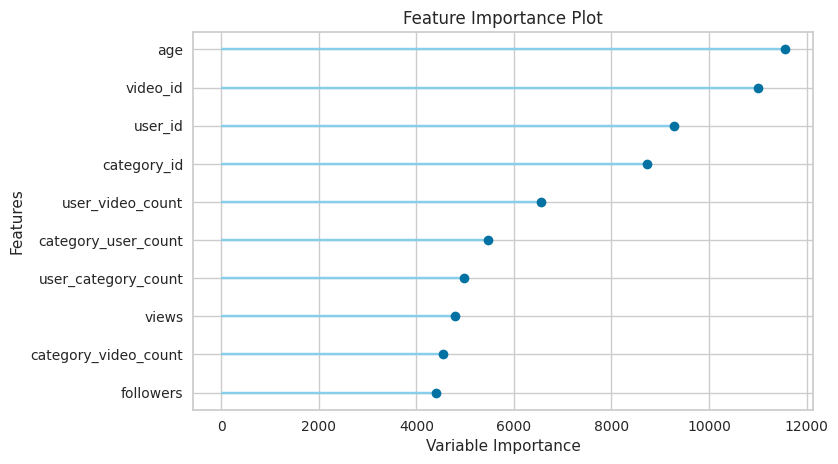

In [59]:
plot_model(lgbm,'feature')

xgboost model

In [32]:
%%time
xgbm=create_model('xgboost',base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.020277635007304968,
             max_delta_step=0, max_depth=11, min_child_weight=4,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=100, reg_alpha=1e-10,
             reg_lambda=1e-10, scale_pos_weight=46.751325738834,
             subsample=0.9840433785610212, tree_method='gpu_hist',
             validate_parameters=1, verbosity=0)
xgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4936,0.4377,0.6616,0.4222,0.1817,0.2498
1,0.4897,0.4434,0.6659,0.4114,0.1828,0.2132
2,0.4918,0.4387,0.6623,0.4167,0.1829,0.1845
3,0.4815,0.4175,0.6462,0.4252,0.1743,0.2583
4,0.5001,0.4540,0.6738,0.3894,0.1842,0.2347
5,0.4843,0.4222,0.6497,0.4271,0.1779,0.2614
6,0.4983,0.4504,0.6711,0.4182,0.1843,0.1960
7,0.4948,0.4444,0.6666,0.4171,0.1856,0.2409
8,0.4922,0.4377,0.6616,0.4087,0.1804,0.2486
9,0.4911,0.4367,0.6609,0.4158,0.1830,0.1882


CPU times: user 6min 14s, sys: 2min 11s, total: 8min 26s
Wall time: 8min 52s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.020277635007304968,
             max_delta_step=0, max_depth=11, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=100, reg_alpha=1e-10,
             reg_lambda=1e-10, scale_pos_weight=46.751325738834,
             subsample=0.9840433785610212, tree_method='gpu_hist',
             validate_parameters=1, verbosity=0)

In [33]:
save_model(xgbm, 'tuned_xgb_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['user_id',
                                                           'category_id',
                                                           'video_id', 'age',
                                                           'gender',
                                                           'profession',
                                                           'followers', 'views',
                                                           'user_video_count',
                                                           'user_category_count',
                                                           'category_user_count',
                                      

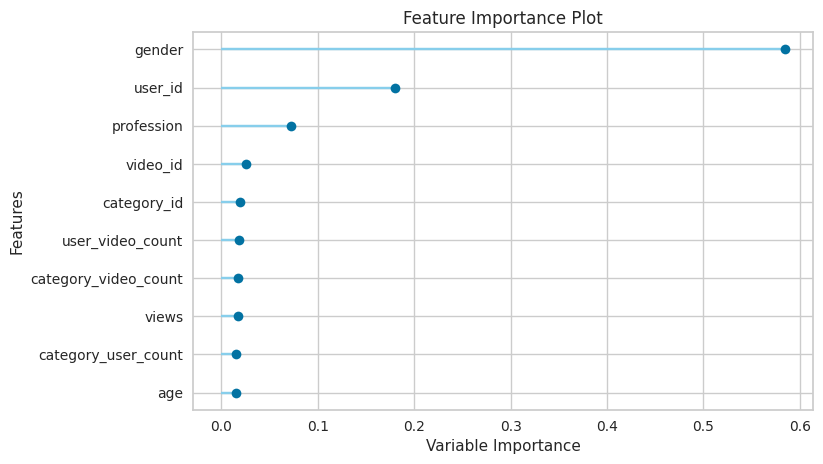

In [33]:
plot_model(xgbm,'feature')

In [34]:
# extratrees=create_model('et')
# extratrees

In [35]:
# save_model(extratrees, 'et_model')

In [36]:
# catboost=create_model('catboost')
# catboost

In [37]:
# save_model(catboost, 'catboost_model')

In [38]:
# rf=create_model('rf')
# rf

In [39]:
# save_model(rf, 'randomforest_model')

Ensemble models

In [40]:
# stacked_model = stack_models([lgbm,xgbm,catboost,rf],
# #                               meta_model=
#                             ),
# stacked_model

In [41]:
# save_model(stacked_model, 'stacked_model_w_tuned_xgbm')

Predictions

In [ ]:
%%time
#test predictions
# final_model = finalize_model(stacked_model[0])
final_model = finalize_model(xgbm)

In [46]:
test_preds = predict_model(final_model, data=test_w_knn)
print(test_preds.head())

   row_id  user_id  category_id  video_id  age  gender  profession  followers  \
0   89198     7986           12        42   14       1           1        180   
1   89199    11278           34       115   14       1           1        230   
2   89200    17245            8       110   44       0           2        280   
3   89201     9851           16       137   18       1           1        270   
4   89202    16008           34        96   47       0           0        230   

   views  user_video_count  ...  category_user_count  category_video_count  \
0    138                 2  ...                 2020                     6   
1    840                 5  ...                 1679                     5   
2    628                 5  ...                 3043                    10   
3    462                 3  ...                 1670                     5   
4    840                 3  ...                 1679                     5   

   category_age_mean  category_gender_mean  

In [47]:
final_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.020277635007304968,
             max_delta_step=0, max_depth=11, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=100, reg_alpha=1e-10,
             reg_lambda=1e-10, scale_pos_weight=46.751325738834,
             subsample=0.9840433785610212, tree_method='gpu_hist',
             validate_parameters=1, verbosity=0)

In [52]:
# %%time
# #train predictions
# train_preds = predict_model(final_model, data=train)
# print(train_preds.head())
# print('full train score:',r2_score(target,train_preds['Label']))

In [48]:
submission = test_preds[['row_id','Label']]
submission=submission.rename(columns={'Label':'engagement_score'})
submission[['row_id','engagement_score']].to_csv('submission.csv',index=False)

In [49]:
test_sub = pd.read_csv('submission.csv')

In [50]:
print(test_sub.shape)
test_sub.head()

(11121, 2)


,row_id,engagement_score
0,89198,4.197085
1,89199,3.970400
2,89200,2.388274
3,89201,2.889002
4,89202,2.074492
